In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -q tensorflow-model-optimization

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix



import dask.dataframe as dd
import csv

import tensorflow as tf
import tensorflow.lite as tflite
import tensorflow_model_optimization as tfmot
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SpatialDropout1D, Reshape, \
                         Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

from sklearn import metrics
from sklearn.preprocessing import Normalizer

from keras import callbacks
from keras.callbacks import CSVLogger
from tensorflow.python.keras import backend as K

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [ ]:
y_train = np.load('drive/MyDrive/Colab Notebooks/y_train_b.npy')
X_test = np.load('drive/MyDrive/Colab Notebooks/X_test_b.npy')
y_test = np.load('drive/MyDrive/Colab Notebooks/y_test_b.npy')
X_train = np.load('drive/MyDrive/Colab Notebooks/X_train_b.npy')

In [ ]:
X_train = np.delete(X_train, 2, axis=1)
X_test = np.delete(X_test, 2, axis=1)
X_train = np.delete(X_train, 1, axis=1)
X_test = np.delete(X_test, 1, axis=1)
X_train = np.delete(X_train, -1, axis=1)
X_test = np.delete(X_test, -1, axis=1)

print(X_train.shape)
print(X_test.shape)
print(X_train)

(609500, 77)
(152376, 77)
[[2.85112400e+06 1.51940347e+09 3.85040000e+06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.26551100e+06 1.51939834e+09 5.66918220e+07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.80904600e+06 1.51876728e+09 4.36062600e+06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.89574000e+05 1.51863011e+09 6.04345890e+07 ... 9.99197733e+06
  2.87720153e+04 1.00038290e+07]
 [1.29854000e+05 1.51862992e+09 2.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.88339300e+06 1.51998297e+09 1.18235757e+08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [ ]:
## minmax scale the arrays
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(X_train.shape)
print(X_test.shape)

(609500, 77)
(152376, 77)


In [ ]:
X_train = X_train.reshape(609500,1,77).astype(np.float32)
X_test = X_test.reshape(152376,1,77).astype(np.float32)
print(X_train.shape)
print(X_test.shape)

(609500, 1, 77)
(152376, 1, 77)


In [ ]:
### Initialize device
device = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device))


Found GPU at: /device:GPU:0


In [ ]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
##### Keras LSTM model (100, 50 encoder scheme)
batch_size = 64

GRADAR = Sequential([
    LSTM(50,input_shape=(1, 77), return_sequences= True),
    Dropout(0.10),
    LSTM(100, return_sequences=True),
    Dropout(0.05),
    Reshape((25,4,1)),
    tfmot.quantization.keras.quantize_annotate_layer(Conv2D(50, 1, activation='relu')),
    tfmot.quantization.keras.quantize_annotate_layer(BatchNormalization()),
    tfmot.quantization.keras.quantize_annotate_layer(MaxPool2D(pool_size=2)),
    tfmot.quantization.keras.quantize_annotate_layer(Conv2D(90, 1, activation='relu')),
    tfmot.quantization.keras.quantize_annotate_layer(BatchNormalization()),
    tfmot.quantization.keras.quantize_annotate_layer(MaxPool2D(pool_size=2)),
    tfmot.quantization.keras.quantize_annotate_layer(Flatten()),
    tfmot.quantization.keras.quantize_annotate_layer(Dense(192, activation='relu')),
    tfmot.quantization.keras.quantize_annotate_layer(Dense(32, activation='relu')),
    tfmot.quantization.keras.quantize_annotate_layer(Dense(1, activation='sigmoid'))
])

GRADAR.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 50)             25600     
                                                                 
 dropout_16 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_17 (LSTM)              (None, 1, 100)            60400     
                                                                 
 dropout_17 (Dropout)        (None, 1, 100)            0         
                                                                 
 reshape_8 (Reshape)         (None, 25, 4, 1)          0         
                                                                 
 quantize_annotate_15 (Quant  (None, 25, 4, 50)        100       
 izeAnnotate)                                                    
                                                      

In [ ]:
strategy = tf.distribute.MirroredStrategy(devices=[device])
device

'/device:GPU:0'

In [ ]:
with tf.device(device):
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
  GRADAR.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
  hist = GRADAR.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
9524/9524 [==============================] - 75s 7ms/step - loss: 0.1573 - accuracy: 0.9458 - val_loss: 0.0811 - val_accuracy: 0.9741
Epoch 2/10
9524/9524 [==============================] - 69s 7ms/step - loss: 0.0767 - accuracy: 0.9727 - val_loss: 0.0579 - val_accuracy: 0.9802
Epoch 3/10
9524/9524 [==============================] - 69s 7ms/step - loss: 0.0637 - accuracy: 0.9773 - val_loss: 0.0522 - val_accuracy: 0.9822
Epoch 4/10
9524/9524 [==============================] - 69s 7ms/step - loss: 0.0589 - accuracy: 0.9789 - val_loss: 0.0514 - val_accuracy: 0.9824
Epoch 5/10
9524/9524 [==============================] - 69s 7ms/step - loss: 0.0556 - accuracy: 0.9800 - val_loss: 0.0482 - val_accuracy: 0.9836
Epoch 6/10
9524/9524 [==============================] - 70s 7ms/step - loss: 0.0535 - accuracy: 0.9807 - val_loss: 0.0494 - val_accuracy: 0.9827
Epoch 7/10
9524/9524 [==============================] - 70s 7ms/step - loss: 0.0520 - accuracy: 0.9813 - val_loss: 0.0516 - val_ac

In [ ]:
GRADAR.save('GRADAR', save_format='tf')

# Confusion Matrix

the confusion matrix is an essential part in finding out just how well the classifier engine has worked.

In [132]:
y_pred = GRADAR.predict(X_test)

4762/4762 [==============================] - 11s 2ms/step


In [133]:
y_pred = np.rint(y_pred)
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [134]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[74749,  1432],
       [ 1732, 74463]])

Normalized confusion matrix
[[0.98120266 0.01879734]
 [0.02273115 0.97726885]]


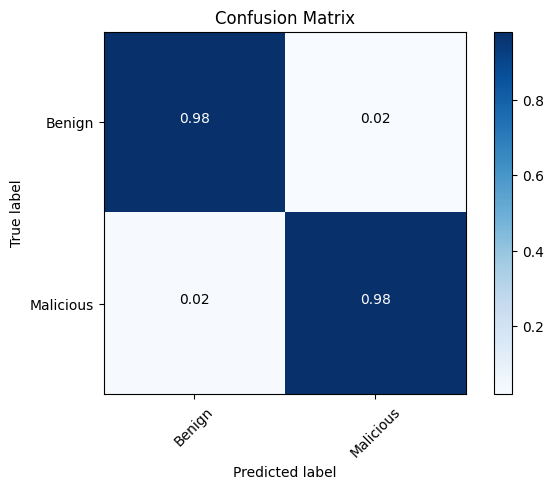

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Benign', 'Malicious']
plt.figure()
plot_confusion_matrix(cm=cm, classes=class_names, normalize=True, title='Confusion Matrix')
plt.show()

In [9]:
# cm = np.array([[74749,  1432],
#        [ 1732, 74463]])

FN = cm[1][0]
FP = cm[0][1]
TP = cm[1][1]
TN = cm[0][0]

##Use formula for accuracy
accuracy = (TP+TN)/(TP+TN+FP+FN)

##Use formula for precision
precision = TP/(TP+FP)

##Use formula for recall
recall = TP/(TP+FN)

##Use formula for F1 score
f1_score = 2*precision*recall/(precision+recall)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.9792355751561925
Precision:  0.9811318268660649
Recall:  0.9772688496620513
F1 Score:  0.979196528371359


In [ ]:
#### Inference
import os
pcap_file_path = './ordered_coalesce_netcat1.pcap'
###### From github--> network attack example
cmd = 'cicflowmeter -f '+ pcap_file_path +' -c Example.csv'
os.system(cmd)

In [125]:
df = pd.read_csv('example_labels.csv')
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df[' Label'] = df[' Label'].replace({'DDoS': 1, 'BENIGN': 0})
df_labels =  df[' Label']
df_labels.value_counts()
df = df.drop(' Label', axis=1)
df = df.drop('Destination Port', axis=1)
X = df.to_numpy()
y = df_labels.to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], 1, X.shape[1]).astype(np.float32)
print(X.shape)
print(y.shape)

(168521, 1, 77)
(168521,)


# Run Inference using GPU

Example inference run on the GPU. Total prediction time is 12 seconds

In [130]:
###Using gpu, run inference
with tf.device(device):
  y_pred = GRADAR.predict(X)
  y_pred = np.rint(y_pred)

unique_values_pred, counts_pred = np.unique(y_pred, return_counts=True)
unique_values_grnd, counts_grnd = np.unique(y, return_counts=True)

max_count_index_pred = np.argmax(counts_pred)
max_count_index_grnd = np.argmax(counts_grnd)
majority_value_pred = unique_values_pred[max_count_index_pred]
majority_value_grnd = unique_values_grnd[max_count_index_grnd]


print(majority_value_pred == majority_value_grnd)

5267/5267 [==============================] - 12s 2ms/step
True
